In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/2Mstd5/With_EFF_CALC'
save = False
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 496 µs, sys: 0 ns, total: 496 µs
Wall time: 933 µs


In [10]:
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[2, std],[3, std],[4, std],[5, std],[6, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000


In [11]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492
2,0.423655,0.645894,2,0,-1.354279,0.203005,1.557284
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900


In [12]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.141471e+00,5.001005e-01,1.385413e+00,1.392225e+00,1.510685e+00
std,2.887267e-01,2.886267e-01,1.719710e+00,5.000001e-01,5.212914e+00,5.209886e+00,7.388442e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-2.474868e+01,-2.259529e+01,-3.382132e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-2.144864e+00,-2.134683e+00,-3.495621e+00
50%,4.999703e-01,5.003810e-01,0.000000e+00,1.000000e+00,1.349885e+00,1.354462e+00,1.472273e+00
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,4.870776e+00,4.880512e+00,6.475585e+00
max,9.999993e-01,9.999997e-01,5.000000e+00,1.000000e+00,2.864246e+01,2.684013e+01,3.683212e+01


In [13]:
data.groupby('C').ITE.mean()

C
0    0.000688
1    1.982160
2    3.003933
3    3.989639
4    5.016455
5    5.982482
Name: ITE, dtype: float64

In [14]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


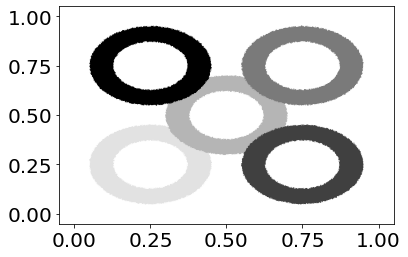

In [15]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [16]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [17]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 1h 22min 38s, sys: 37 s, total: 1h 23min 15s
Wall time: 1h 23min 22s


In [18]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,2.494410,-6.695489
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,0.877852,-2.880159
2,0.423655,0.645894,2,0,-1.354279,0.203005,1.557284,1,5.339258,6.693537
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817,0,2.651884,2.616681
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900,0,1.398990,11.878142


### Model performance

In [19]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        1.003019  1.007931  1.089916  0.004912  0.086898
            1        0.996061  0.977450  1.087502 -0.018611  0.091441
          1 0        0.014185  2.004158  1.875784  1.989973  1.861600
            1       -0.017873  2.066829  1.868338  2.084702  1.886211
          2 0       -0.029741  3.029716  2.905828  3.059457  2.935569
            1       -0.019285  2.985185  2.896890  3.004469  2.916175
          3 0        0.022727  3.988244  3.826993  3.965517  3.804266
            1       -0.065320  4.040098  3.832964  4.105418  3.898284
          4 0       -0.000843  5.022746  4.831618  5.023589  4.832461
            1        0.025607  4.945899  4.822774  4.920292  4.797167
          5 0        0.004174  6.036777  5.790356  6.032603  5.786182
            1        0.042867  5.964561  5.796863  5.921694  5.753996
1         0 0        1.004904  1.002898  0.929440  0.002006  0.075464
            1        1.002823  1.005095  0.936726 -0.002272  0.066097
          1 0        1.977054  0.011221  0.131186  1.965834  1.845869
            1        1.943217  0.029556  0.137547  1.913661  1.805670
          2 0        2.975536  0.014593  0.101209  2.960943  2.874327
            1        3.022097  0.068924  0.098205  2.953174  2.923892
          3 0        3.986992  0.005630  0.154767  3.981363  3.832226
            1        3.991202 -0.010284  0.147832  4.001485  3.843369
          4 0        5.020679 -0.000282  0.121989  5.020961  4.898690
            1        5.035872 -0.030161  0.116300  5.066033  4.919572
          5 0        5.979136  0.041450  0.119034  5.937686  5.860102
            1        6.008861 -0.012104  0.120379  6.020965  5.888482

### Apply clustering Box and Kmeans

In [20]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 20h 30min 23s, sys: 1h 36min 16s, total: 22h 6min 40s
Wall time: 1h 56min 41s


In [21]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,2.494410,-6.695489,982,675
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,0.877852,-2.880159,762,203
2,0.423655,0.645894,2,0,-1.354279,0.203005,1.557284,1,5.339258,6.693537,866,271
3,0.437587,0.891773,0,1,5.268565,7.564383,-2.295817,0,2.651884,2.616681,1200,1166
4,0.963663,0.383442,0,0,-10.479152,0.651748,11.130900,0,1.398990,11.878142,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [22]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [23]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.493584,1409.0,1.0,0.000705
1,1,-0.134775,1451.0,1.0,0.000726
2,2,0.101705,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


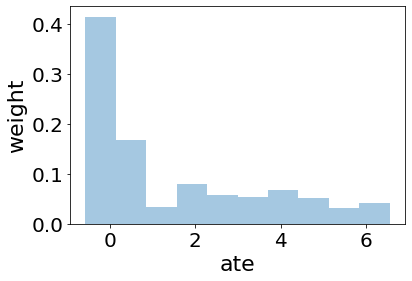

In [24]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



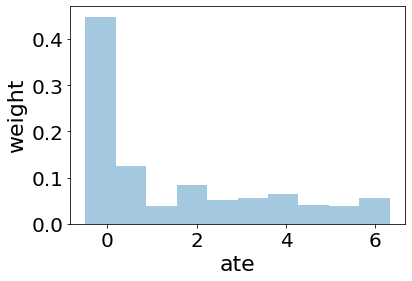

In [25]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


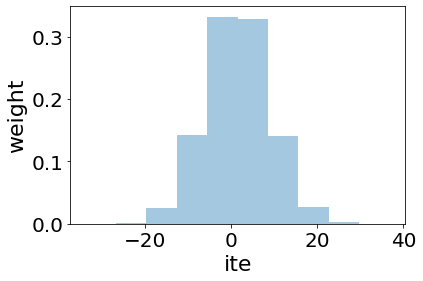

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 10,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [27]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.511913,1460.920380,0.940551,0.000730
std,395.34057,1.982854,37.097551,0.123603,0.000019
min,0.00000,-0.568459,1345.000000,0.486869,0.000673
25%,342.00000,0.000605,1435.000000,0.977417,0.000718
50%,684.00000,0.262450,1460.000000,1.000000,0.000730
75%,1026.00000,2.964135,1486.000000,1.000000,0.000743
max,1368.00000,6.550324,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [28]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


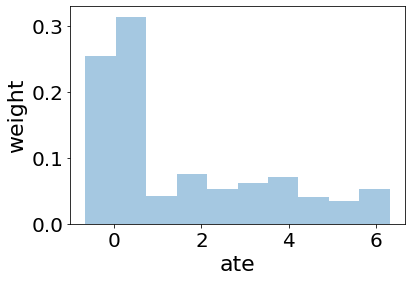

In [29]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


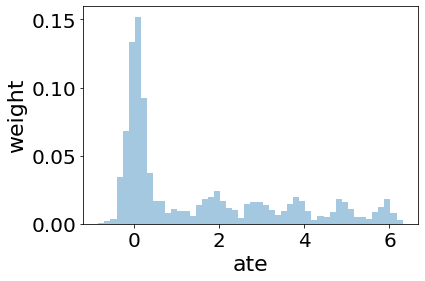

In [45]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = 50, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

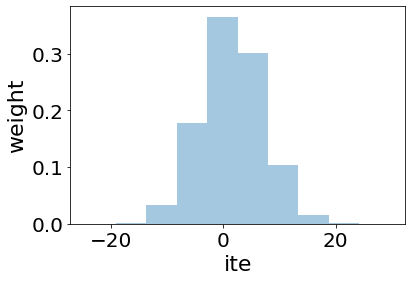

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})

ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Weighted Kmeans 6-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [32]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 6
for dd, name, name2,w in zip(all_data, names_to_give, names_to_find,weights):
    kmeans_clustering(dd, clusters = clusts, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 1.39 s, sys: 57.6 ms, total: 1.45 s
Wall time: 261 ms


In [33]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.493584,1409.0,1.0,0.000705,0
1,1,-0.134775,1451.0,1.0,0.000726,0


In [34]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,2.494410,-6.695489,982,675
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,0.877852,-2.880159,762,203


### 6 Clustering in the ITEs

In [35]:
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 2 Clustering with initial data

In [36]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [37]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,9.189899,9.564236,0.374337,1,2.494410,-6.695489,982,675,5,3,3,2,1,3
1,0.602763,0.544883,0,0,3.758011,5.481504,1.723492,0,0.877852,-2.880159,762,203,0,1,3,2,3,3


### Plot reconstruction of data

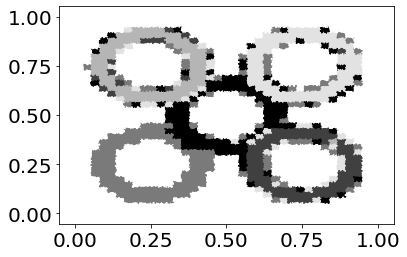

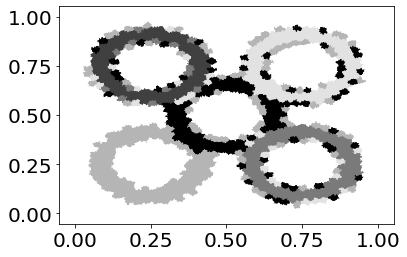

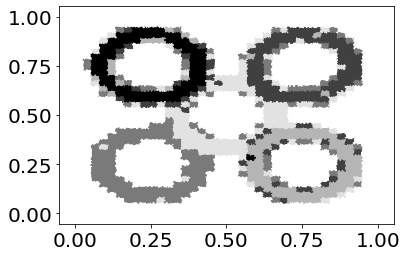

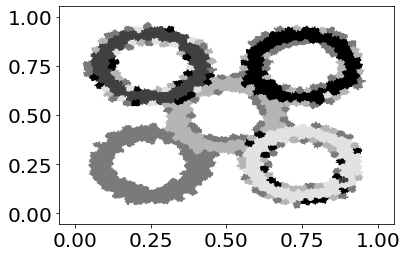

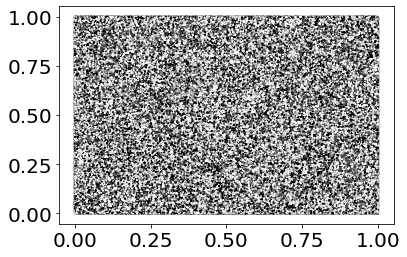

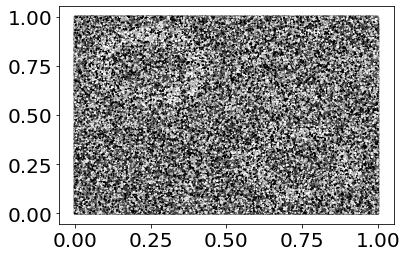

CPU times: user 5min 13s, sys: 7.86 s, total: 5min 21s
Wall time: 5min 14s


In [38]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:

        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [39]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [40]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [41]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [42]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [43]:
errors.sort_values(by = 'mean')

,mean,std
Box2-Cl2-err-True-ITE,0.506434,0.738355
Box-Cl2-err-True-ITE,0.511455,0.734191
Box2-Cl2-err-GDBR,0.511777,0.703151
Box-Cl2-err-GDBR,0.517595,0.694808
Kmeans2-Cl2-err-True-ITE,0.519475,0.736142
Kmeans-Cl2-err-True-ITE,0.521694,0.736007
Kmeans2-Cl2-err-GDBR,0.524074,0.702942
Kmeans-Cl2-err-GDBR,0.527662,0.698276
ITE-2CTrue-err-GDBR,2.981713,2.322110
ITE-2CGDBR-err-True-ITE,3.904593,2.908292


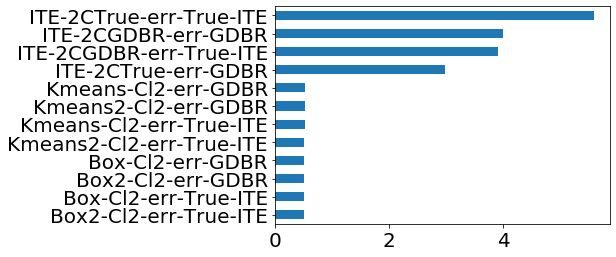

In [44]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()